In [0]:
import torch
from torch import nn
import numpy as np
from torchvision import transforms, models
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
vgg = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:15<00:00, 36.7MB/s]


In [0]:
vgg_feat = vgg.features.cuda()

In [0]:
for param in vgg_feat.parameters():
  param.requires_grad_(False)

In [0]:
#loading style and content image
content_img = Image.open('images1.jpg')
style_img = Image.open('images.jpg')

In [7]:
content_img.size, style_img.size

((679, 452), (739, 415))

In [0]:
im_transform = transforms.Compose([transforms.Resize((400,650), ), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [0]:
style, content = im_transform(style_img).unsqueeze(0).cuda(), im_transform(content_img).unsqueeze(0).cuda()

In [10]:
style.shape, content.shape

(torch.Size([1, 3, 400, 650]), torch.Size([1, 3, 400, 650]))

In [0]:
# denormalizing the normalized tensor to view original unnormalized image
def show(image):
  image = image.to('cpu').clone()
  image = image.detach().numpy().squeeze()
  image = np.transpose(image, (1,2,0))
  image = image*np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0,1)
  return image

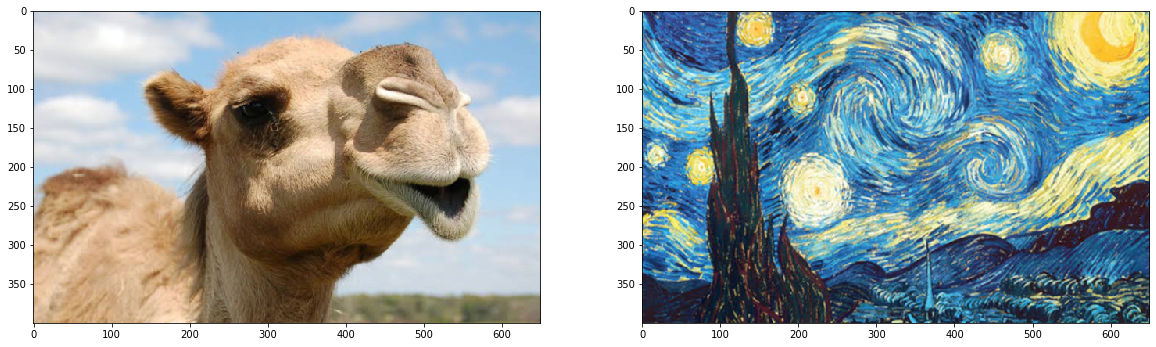

In [12]:
a, (b, c )= plt.subplots(1, 2, figsize=(20,10))
b.imshow(show(content))
c.imshow(show(style))

In [0]:
# extract the features from layers given in the image style transfer using cnn paper
def getFeat(image, model, layers = None):
  if layers == None:
    layers = {'0':'conv1_1',
              '5':'conv2_1',
              '10':'conv3_1',
              '19':'conv4_1',
              '21':'conv4_2',
              '28':'conv5_1',
    }

  style_features = {}
  x = image
  for name, layer in model._modules.items():
    x = layer(x)
    if name in layers:
      style_features[layers[name]] = x
  return style_features

In [0]:
# gram matrix to find the correlation in the different filters in a layer
def gramMatrix(tensor):
  _, d, h, w = tensor.size()
  tensor = tensor.view(-1, h*w)
  return torch.mm(tensor, tensor.T)

In [0]:
style_features = getFeat(style, vgg_feat)
style_grams = {}
for layer in style_features:
  style_grams[layer] = gramMatrix(style_features[layer])

In [0]:
target = content.clone().requires_grad_(True).cuda()

In [0]:
#random style weights to find the style gram loss
style_weight = {'conv1_1':1.,
                'conv2_1':.75,
                'conv3_1':.75,
                'conv4_1':0.50,
                'conv5_1':0.2,
}

# apha is kept greater than beta to impose style on the content image
alpha = 1 #content weight
beta = 1e6 #style weight

In [0]:
from torch import optim
optimizer = optim.Adam([target], lr = 0.005)

Total Loss: 23622074.000


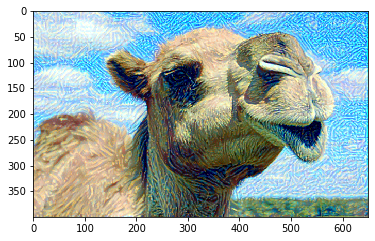

Total Loss: 7841621.500


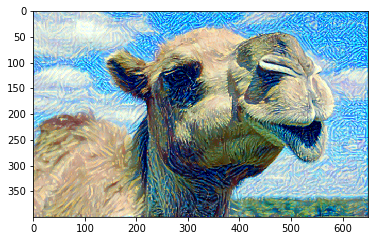

Total Loss: 3548580.500


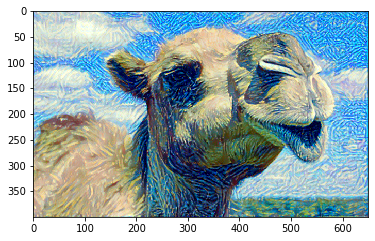

Total Loss: 1875668.750


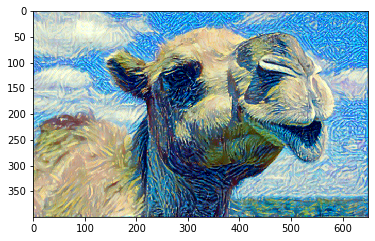

Total Loss: 1049963.250


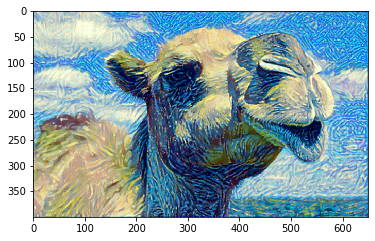

Total Loss: 621715.000


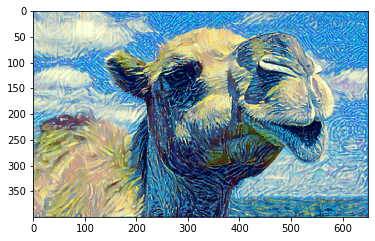

Total Loss: 390030.969


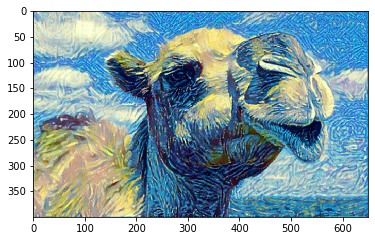

Total Loss: 258088.625


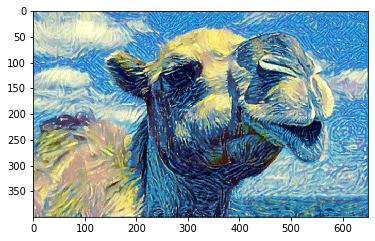

Total Loss: 181195.750


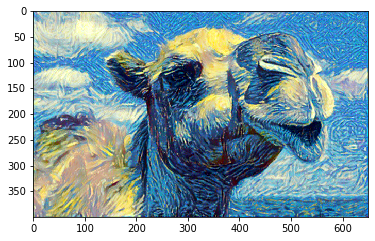

Total Loss: 136456.391


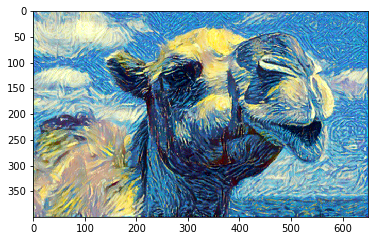

In [23]:
for i in range(1, 8001):
  target_features = getFeat(target, vgg_feat)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

  style_loss = 0
  for layer in style_weight:
    target_feature = target_features[layer]
    target_gram = gramMatrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    style_gram_loss = style_weight[layer]*torch.mean((style_gram - target_gram)**2)
    style_loss += style_gram_loss/(d*h*w)

  total_loss = style_loss*beta + content_loss*alpha

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i%800 == 0:
    print('Total Loss: {:.3f}'.format(total_loss.item()))
    plt.imshow(show(target))
    plt.show()

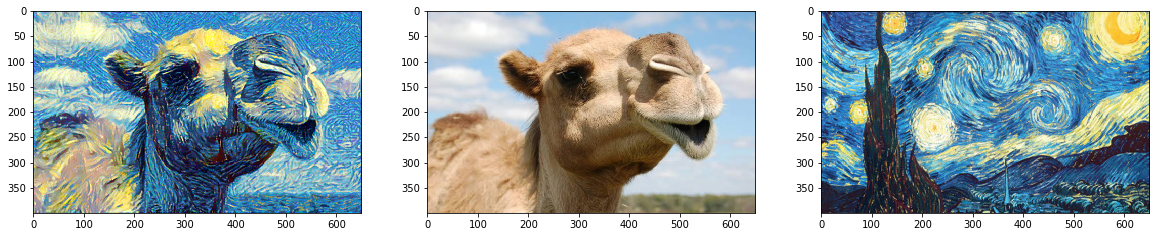

In [24]:
fig, (a, b, c) = plt.subplots(1, 3, figsize=(20,10))
a.imshow(show(target))
b.imshow(show(content))
c.imshow(show(style))

In [0]:
from matplotlib.image import imsave
imsave('final.png', show(target))